In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import psutil
from pathlib import Path
import os
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

2024-11-11 10:24:56.513410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731320696.524296   38544 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731320696.527587   38544 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 10:24:56.540512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
PATH = Path("dataset") / "GTSRB" / "Training"
_N = 32
LABELS = ["20 km/h"
,"30 km/h"
,"50 km/h"
,"60 km/h"
,"70 km/h"
,"80 km/h"
,"End of speed limit"
,"100 km/h"
,"120 km/h"
,"No passing"
,"No passing for large vehicles"
,"Right of way"
,"Priority road"
,"Yield"
,"Stop"
,"No vehicles"
,"Large vehicles prohibited"
,"No entry"
,"General caution"
,"Dangerous curve to the left"
,"Dangerous curve to the right"
,"Double curve"
,"Bumpy road"
,"Slippery road"
,"Road narrows"
,"Road work"
,"Traffic signals"
,"Pedestrians"
,"Children crossing"
,"Bicycle crossing"
,"Ice warning"
,"Wild animals crossing"
,"End of all speed and passing limits"
,"Turn right ahead"
,"Turn left ahead"
,"Ahead only"
,"Go straight or right"
,"Go straight or left"
,"Keep right"
,"Keep left"
,"Roundabout mandatory"
,"End of no passing"
,"End of no passing by large vehicles"]

In [3]:
model = tf.keras.models.load_model("model.keras")


I0000 00:00:1731320698.789208   38544 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6


In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
  PATH,
  label_mode="int",
  seed=42,
  image_size=(_N, _N),
  color_mode="rgb",
  shuffle=True)
dataset.class_names = LABELS

Found 39209 files belonging to 43 classes.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


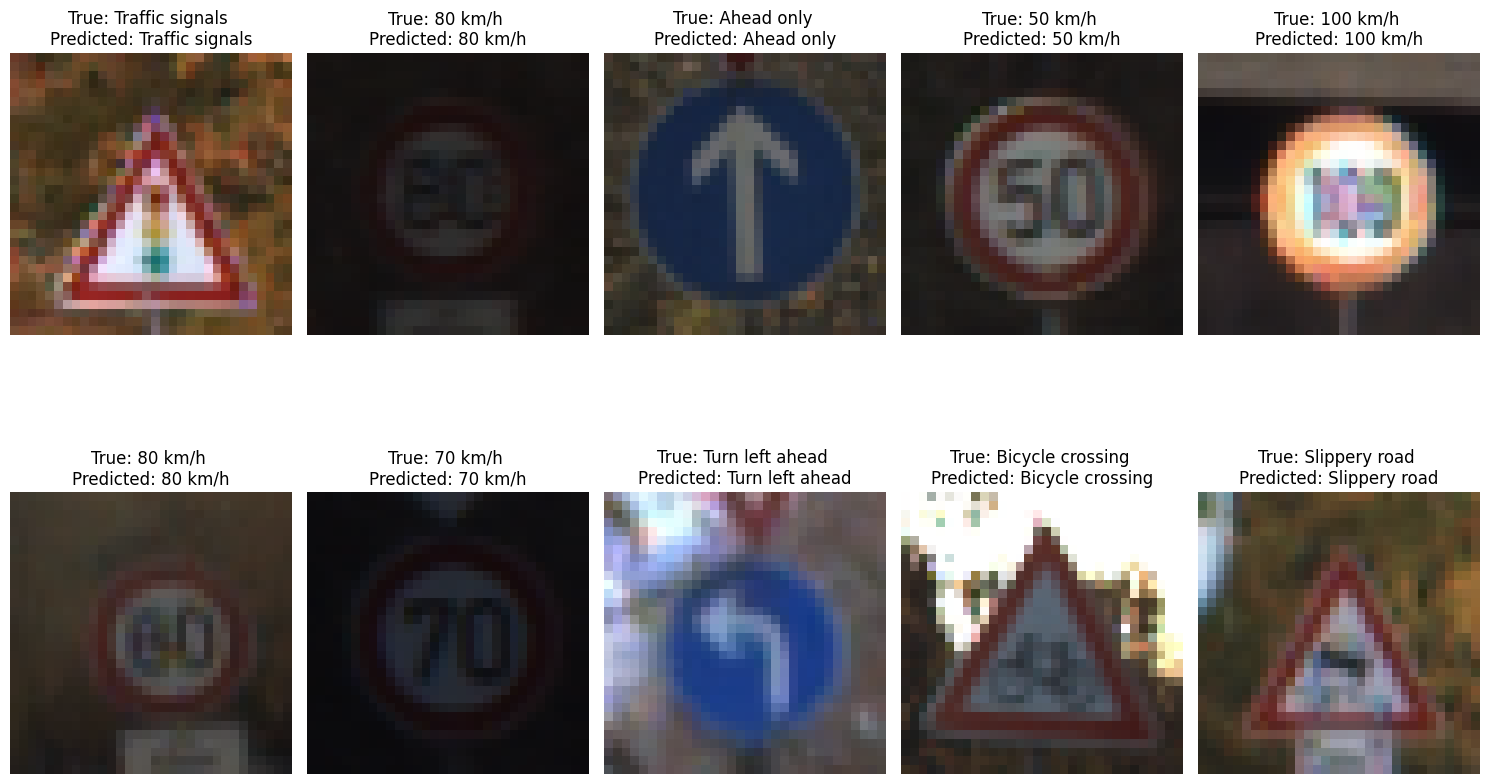

In [7]:
def show_predictions(model,n):
    images = []
    labels = []
    for img,label in dataset.take(n):
        images.extend(img)
        labels.extend(label)
    images = np.array(images)
    labels = np.array(labels)
    predictions = model.predict(images)
    

    predicted_classes = np.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(n):
        true = labels[i]
        pred = predicted_classes[i]
        img = images[i]
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.astype("uint8"))
        plt.title(f"True: {LABELS[true]} \nPredicted: {LABELS[pred]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_predictions(model,10)

2024-11-11 10:25:37.117835: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Precision (macro): 0.9983
Recall (macro): 0.9975
F1-score (macro): 0.9979


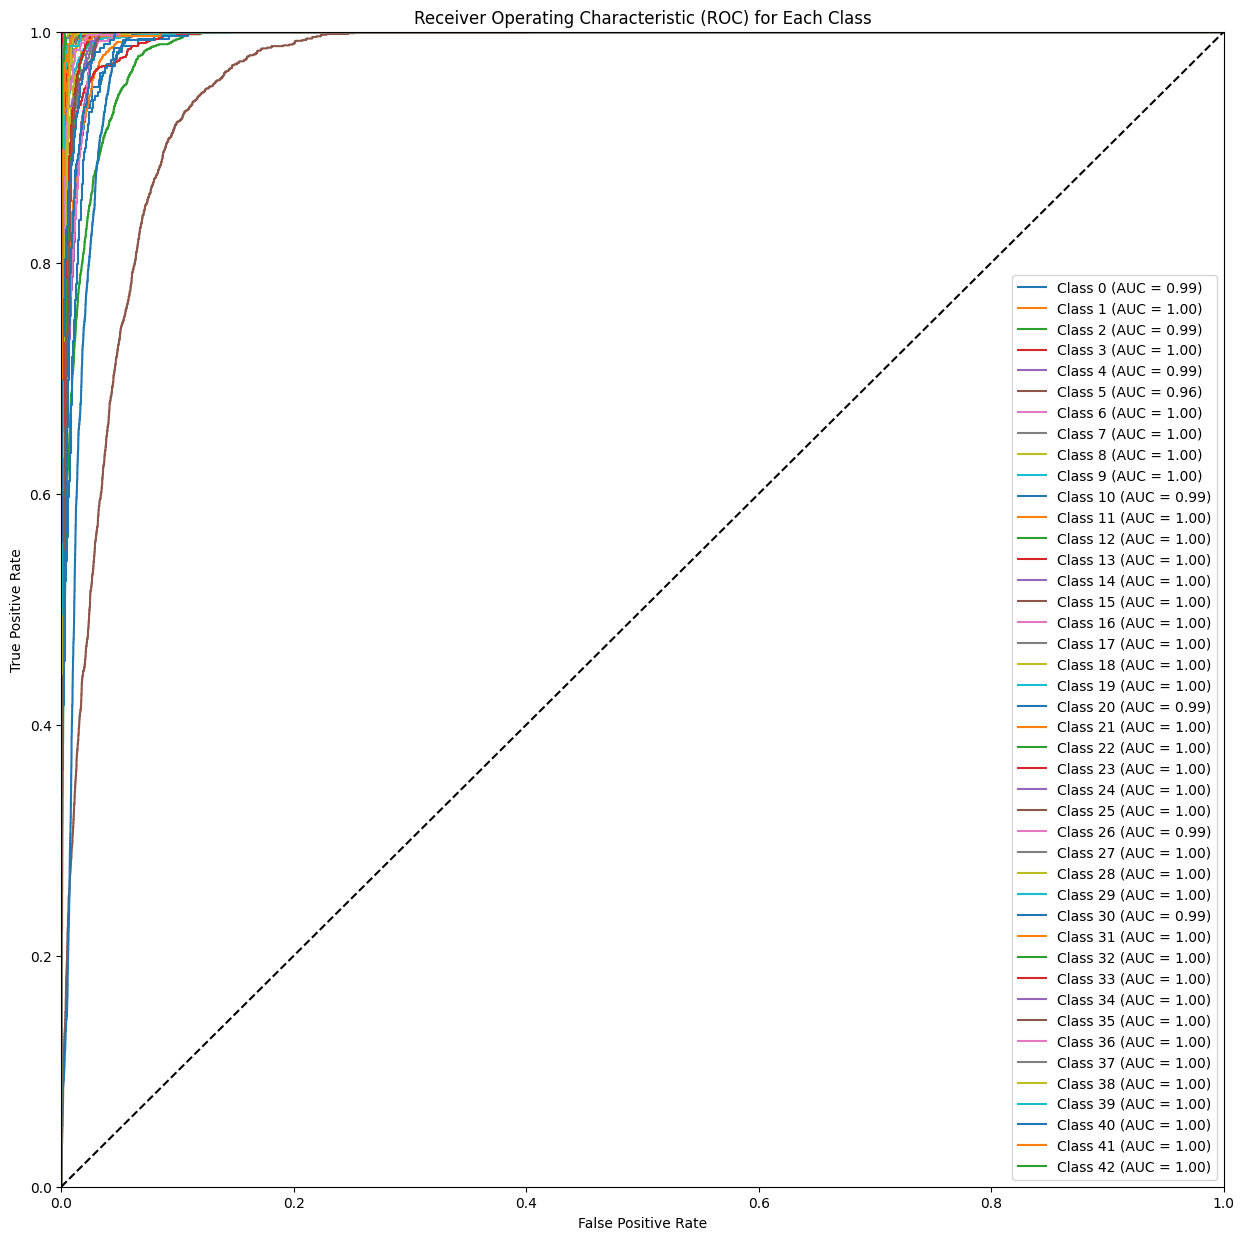

In [6]:
def print_metrics(model,test_dataset):
    y = []
    y_pred_prob = []

    # Iterate through the test dataset
    for images, labels in test_dataset:
        y.extend(np.array(labels))
        predictions = model.predict(images,verbose=0)
        y_pred_prob.extend(predictions)
    y = np.array(y)
    y_pred_prob = np.array(y_pred_prob)
    y_pred_class = np.argmax(y_pred_prob,axis=1)

    precision = precision_score(y, y_pred_class, average='macro')
    recall = recall_score(y, y_pred_class, average='macro')
    f1 = f1_score(y, y_pred_class, average='macro')

    # Display the macro/micro/weighted average metrics
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')

    # Binarize the output (needed for multiclass ROC)
    # This turns the class labels into a one-vs-rest binary format
    y_test_bin = label_binarize(y, classes=np.arange(43))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(43):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(15, 15))
    for i in range(43):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Each Class')
    plt.legend(loc='lower right')
    plt.show()
print_metrics(model,dataset.take(1000))